# Clasificación de imagenes en dos categorías

Voy a intentar usar este pequeño dataset de kaggle, originariamente pensado para learning transfer, para entrenar una red neuronal convolucional capaz de distinguir imagenes de Alien de imagenes de Predator.

Ya que el tamaño de la muestra es muy reducido, miraré qué efecto tiene el uso de técnicas de data augmentation:
- entrenamiento: 247 Aliens y 247 Predators;
- validación: 100 Aliens y 100 Predators
- he decidido separar el conjunto de validación en dos mitades, una de validación y una de test

Como se verá más tarde, las etiquetas de las imagenes son:
- Alien: 0
- Predator: 1

Link a kaggle: https://www.kaggle.com/pmigdal/alien-vs-predator-images

## 1. Preparo el dataset

In [1]:
import os, shutil

# Carpeta base
PWD = os.getcwd()
base_dir = PWD + '/alien_vs_predator_thumbnails/data'

# Carpeta con imagenes de entrenamiento
train_dir = os.path.join(base_dir, 'train')
# Alien
train_dir_alien = os.path.join(train_dir, 'alien')
# Predator
train_dir_predator = os.path.join(train_dir, 'predator')

# Carpeta con imagenes de validación
validation_dir = os.path.join(base_dir, 'validation')
# Alien
validation_dir_alien = os.path.join(validation_dir, 'alien')
# Predator
validation_dir_predator = os.path.join(validation_dir, 'predator')

# Carpeta con imagenes de test
test_dir = os.path.join(base_dir, 'test')
# Alien
test_dir_alien = os.path.join(test_dir, 'alien')
# Predator
test_dir_predator = os.path.join(test_dir, 'predator')

In [2]:
# Verifio si he hecho todo como quería

print('Training images:')
print('total training Alien images:', len(os.listdir(train_dir_alien)))
print('total training Predator images:', len(os.listdir(train_dir_predator)))
print("\n")

print('Validation images:')
print('total validation Alien images:', len(os.listdir(validation_dir_alien)))
print('total validation Predator images:', len(os.listdir(validation_dir_predator)))
print("\n")

print('Test images:')
print('total test Alien images:', len(os.listdir(test_dir_alien)))
print('total test Predator images:', len(os.listdir(test_dir_predator)))

Training images:
total training Alien images: 347
total training Predator images: 347


Validation images:
total validation Alien images: 50
total validation Predator images: 50


Test images:
total test Alien images: 50
total test Predator images: 50


## 2. Pre-proceso las imágenes

Aplico una serie de transformaciones a las imágenes, para que estén en el formato correcto para que keras las pueda utilizar:
- rescalo los valores de los pixeles para que estén en el rango (0,1)
- hago que todas las imagenes tengan el mismo tamaño (250 x 250), sugerido en la página de kaggle.

Además, digo a keras que juegue con el data augmentation en varias maneras, para obtener, aunque de manera artificial, un dataset más grande. Las imagenes usada serán las originales, y también una serie de tranformación de estas:
- se les dará la vuelta horizontalmente;
- se les dará la vuelta verticalmente;
- se les rotará de hasta 90 grados;
- se cambiará las luminosidad de un factor entre 0.2 y 1;
- se aplicará un zoom de 0.5 a 2.

In [3]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255,
                                  horizontal_flip=True,
                                  vertical_flip=True,
                                  rotation_range=90,
                                  brightness_range=[0.2,1.0],
                                  zoom_range=[0.5,1.0])

test_datagen = ImageDataGenerator(rescale=1./255)
""",
                                 horizontal_flip=True,
                                 vertical_flip=True,
                                 brightness_range=[0.2,1.0],
                                 rotation_range=90,
                                 zoom_range=[0.5,1.0])
"""
validation_datagen = ImageDataGenerator(rescale=1./255)
""",
                                       horizontal_flip=True,
                                       vertical_flip=True,
                                       rotation_range=90,
                                       brightness_range=[0.2,1.0],
                                       zoom_range=[0.5,1.0])
"""
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=(250, 250),
                                                    batch_size=20,
                                                    class_mode='binary')

test_generator = test_datagen.flow_from_directory(test_dir,
                                                  target_size=(250, 250),
                                                  batch_size=100,
                                                  class_mode='binary')

validation_generator = validation_datagen.flow_from_directory(validation_dir,
                                                              target_size=(250, 250),
                                                              batch_size=20,
                                                              class_mode='binary')

Using TensorFlow backend.


Found 694 images belonging to 2 classes.
Found 100 images belonging to 2 classes.
Found 100 images belonging to 2 classes.


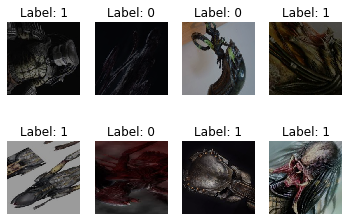

In [4]:
# Miro unas imagenes y sus etiquetas
import matplotlib.pyplot as plt

num_row = 2
num_col = 4
num = num_row * num_col

fig, axes = plt.subplots(num_row, num_col, figsize=(1.5*num_col,2*num_row))

x,y = train_generator.next()

for i in range(0,num):
    ax = axes[i//num_col, i%num_col]
    ax.set_axis_off()
    image = x[i]
    
    # label
    label = int(y[i])
    
    ax.imshow(image)
    ax.set_title('Label: {}'.format(label))
plt.axis('off')
plt.show()

## 3. Defino y entreno la red convolucional

### Estructura

In [5]:
from keras.layers import Dense, Dropout, Activation, Flatten
from keras import layers
from keras import models
from keras import regularizers

model = models.Sequential()

model.add(layers.Conv2D(32, (3,3), activation='relu', input_shape=(250,250,3)))
model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format=None))

model.add(layers.Conv2D(64, (3,3), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format=None))

model.add(layers.Conv2D(128, (3,3), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format=None))

model.add(layers.Conv2D(128, (3,3), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format=None))

model.add(layers.Flatten())

model.add(layers.Dense(512, activation='relu'))

model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 248, 248, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 124, 124, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 122, 122, 64)      18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 61, 61, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 59, 59, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 29, 29, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 27, 27, 128)      

### Optimizador y función de pérdida

In [6]:
from keras import optimizers
from keras.callbacks import EarlyStopping
              
rms = optimizers.RMSprop(lr=5e-4)

es = EarlyStopping(monitor='val_acc', mode='max', patience = 5,
                  restore_best_weights = True)

model.compile(optimizer = rms,             
               loss = "binary_crossentropy", 
               metrics=['acc'])

### Entrenamiento

In [7]:
history = model.fit_generator(train_generator,
                                epochs = 30,
                                validation_data = validation_generator,
                                callbacks = [es])

Epoch 1/30
35/35 [==============================] - 36s 1s/step - loss: 0.7335 - acc: 0.5749 - val_loss: 0.6529 - val_acc: 0.6000
Epoch 2/30
35/35 [==============================] - 36s 1s/step - loss: 0.6321 - acc: 0.6657 - val_loss: 0.5891 - val_acc: 0.6800
Epoch 3/30
35/35 [==============================] - 36s 1s/step - loss: 0.6095 - acc: 0.7075 - val_loss: 0.5426 - val_acc: 0.6800
Epoch 4/30
35/35 [==============================] - 37s 1s/step - loss: 0.5841 - acc: 0.7147 - val_loss: 0.6229 - val_acc: 0.7100
Epoch 5/30
35/35 [==============================] - 37s 1s/step - loss: 0.5987 - acc: 0.7075 - val_loss: 0.5936 - val_acc: 0.6900
Epoch 6/30
35/35 [==============================] - 36s 1s/step - loss: 0.5692 - acc: 0.7262 - val_loss: 0.4784 - val_acc: 0.7300
Epoch 7/30
35/35 [==============================] - 36s 1s/step - loss: 0.5367 - acc: 0.7435 - val_loss: 0.7055 - val_acc: 0.6200
Epoch 8/30
35/35 [==============================] - 37s 1s/step - loss: 0.5527 - acc: 0.73

## 4. Miro la accuracy en el dataset de test

In [8]:
# Miro la accuracy en el test
test_loss, test_acc = model.evaluate(test_generator, verbose = 0)
print('Test loss:', test_loss)
print('Test accuracy:', test_acc)

Test loss: 0.5240777730941772
Test accuracy: 0.7099999785423279


In [10]:
# Pinto la matriz de confusión
import sklearn.metrics as metrics
import numpy as np

x,y = test_generator.next()

predictions = model.predict_generator(test_generator)
predicted_classes = np.around(predictions)

matrix = metrics.confusion_matrix(y, np.around(model.predict(x)))
matrix

array([[40, 10],
       [19, 31]])

## 5. Miro unas imagenes y como se han clasificado

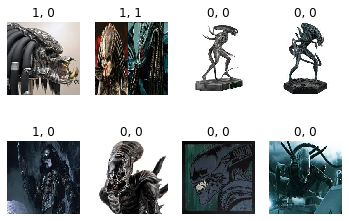

In [11]:
import matplotlib.pyplot as plt

num_row = 2
num_col = 4
num = num_row * num_col

fig, axes = plt.subplots(num_row, num_col, figsize=(1.5*num_col,2*num_row))

x,y = test_generator.next()

for i in range(0,num):
    ax = axes[i//num_col, i%num_col]
    ax.set_axis_off()
    image = x[i]
    
    # label
    true_label = int(y[i])
    predicted_score = model.predict(x)[i]
    predicted_label = int(np.around(model.predict(x)[i]))                                
    final_label = str(true_label) + ", " + str(predicted_label)
    
    ax.imshow(image)
    ax.set_title('{}'.format(final_label))
plt.axis('off')
plt.show()